In [1]:
import matplotlib.pyplot as plt
import torch as tc
import math
import time
import cv2 as cv
import numpy as np

In [2]:
tc.set_default_dtype(tc.float64)

In [91]:
#定义场景的属性
def sphere(center,r,color):
    return {"center":tc.tensor([center]).cuda(),
            "r":r,
            "color":tc.tensor([color]).cuda()}
sence=[sphere(center=[-3,-6.0,150],r=6,color=[1,0,0]),
       sphere(center=[2,6.0,180],r=7,color=[0,1,0]),
       sphere(center=[0,0.0,210],r=9,color=[0,0,1])]
center=[sence[i]["center"] for i in range(len(sence))]
center=tc.cat(center)
color=[sence[i]["color"] for i in range(len(sence))]
color=tc.cat(color)

In [92]:
#寻找交点距离
def sphere_cross(module,ray_origin,ray_dir):
    oc=module["center"]-ray_origin
    oc_n=tc.unsqueeze(tc.norm(oc,dim=-1),dim=-1)
    projection=tc.matmul(oc,ray_dir.T)
    theta_1=tc.acos(projection/oc_n)
    theta_2=tc.asin(module["r"]/oc_n)
    dis=projection-tc.sqrt(module["r"]**2-(oc_n**2-projection**2))
    dis[tc.squeeze(oc_n)<module["r"]]=tc.inf
    dis[theta_1>theta_2]=tc.inf
    return dis
#寻找最近交点距离
def shortest_dis(sence,ray_origin,ray_dir):
    a=tc.matmul(ray_origin,ray_dir.T).size()
    dis=(tc.ones(a)*tc.inf).cuda().to(tc.float64)
    index=(tc.zeros(a).type(tc.LongTensor)).cuda()
    for i in range(len(sence)):
        dis_s=sphere_cross(sence[i],ray_origin,ray_dir)
        index[dis_s<dis]=i
        dis[dis_s<dis]=dis_s[dis_s<dis]
    return dis,index

In [93]:
#阴影找最近交点
def shadow_sphere(module,ray_origin,ray_dir):
    a=ray_origin.size(0)
    oc=module["center"]-ray_origin
    oc_n=tc.norm(oc,dim=1)
    projection=tc.squeeze(tc.matmul(oc.reshape([a,1,3]),ray_dir.reshape([a,3,1])))
    theta_1=tc.acos(projection/oc_n)
    theta_2=tc.asin(module["r"]/oc_n)
    dis=projection-tc.sqrt(module["r"]**2-(oc_n**2-projection**2))
    dis[theta_1>theta_2]=tc.inf
    dis[oc_n<module["r"]]=tc.inf
    return dis
def shadow(sence,ray_origin,ray_dir,index):
    a=len(ray_origin)
    shadow_dis=(tc.ones(a)*tc.inf).cuda()
    for i in range(len(sence)):
        dis=shadow_sphere(sence[i],ray_origin,ray_dir)
        dis[index==i]=tc.inf
        shadow_dis[dis<shadow_dis]=dis[dis<shadow_dis]
    return shadow_dis

In [94]:
#光源属性
souce={"position":tc.tensor([[-100,100,0]]).cuda(),"color":tc.tensor([[1,1,1]]).cuda()}
#Phong反射
ka,kd,ks,alpha=0.3,0.7,0.5,7
w,h=768,1024
pixl=2.6*10**-2#mm
lamda=5.32*10**-4
c,p=tc.min(center[:,2],0)
d,q=tc.max(center[:,2],0)
k=int(d-c+sence[p]["r"]+sence[q]["r"])*10
phi=2*tc.pi*tc.rand(400,600,k)#0.1mm一个相位
pixl_num=32

In [95]:
w_mesh=tc.linspace(-(w/2-pixl_num/2)*pixl,(w/2-pixl_num/2)*pixl,int(w/pixl_num))
h_mesh=tc.linspace(-(h/2-pixl_num/2)*pixl,(h/2-pixl_num/2)*pixl,int(h/pixl_num))
[x,y]=tc.meshgrid(w_mesh,h_mesh)
origin=tc.zeros(int(w/pixl_num),int(h/pixl_num),3)
origin[:,:,0]=x
origin[:,:,1]=y
origin=origin.cuda().to(tc.float64)

In [96]:
w_mesh=tc.linspace(-(w/2-1/2)*pixl,(w/2-1/2)*pixl,w)
h_mesh=tc.linspace(-(h/2-1/2)*pixl,(h/2-1/2)*pixl,h)
[x,y]=tc.meshgrid(w_mesh,h_mesh)
origin_p=tc.zeros(w,h,3)
origin_p[:,:,0]=x
origin_p[:,:,1]=y
origin_p=origin_p.reshape(int(w/pixl_num),pixl_num,int(h/pixl_num),pixl_num,3)
origin_p=tc.permute(origin_p,[0,2,1,3,4])
origin_p=origin_p.cuda().to(tc.float64)
# origin_p=tc.unsqueeze(origin_p,dim=-4)

In [98]:
#虚拟光线在视锥体底面上均匀取(四棱锥高设为1)
theta=math.asin(lamda/(2*pixl))
n=int(2*theta/math.pi*180/(1/60))
light_dir=tc.zeros(n**2,3)
x=tc.linspace(-math.tan(theta),math.tan(theta),n)
x,y=tc.meshgrid(x,x)
norm=tc.sqrt(x**2+y**2+1)
light_dir[:,0]=(x/norm).view(-1)
light_dir[:,1]=(y/norm).view(-1)
light_dir[:,2]=(1/norm).view(-1)

In [99]:
%%time
b=len(light_dir)
light_dir=light_dir.cuda().to(tc.float64)
image=tc.zeros(w,h,dtype=tc.cfloat).cuda()
# color_image=tc.zeros(w,h,3,dtype=tc.cfloat).cuda()
########
for i in range(int(w/pixl_num)):
    for j in range(int(h/pixl_num)):
        dis,index=shortest_dis(sence,origin[i,j].reshape(1,3),light_dir)
        coord=tc.unsqueeze(origin[i,j].reshape(1,3),dim=-2)+light_dir*tc.unsqueeze(dis,dim=-1)
        L=(souce["position"]-coord)/tc.unsqueeze(tc.norm(souce["position"]-coord,dim=-1),dim=-1)
        N=(coord-center[index])/tc.unsqueeze(tc.norm(coord-center[index],dim=-1),dim=-1)
        L_N=tc.matmul(tc.unsqueeze(L,dim=-2),tc.unsqueeze(N,dim=-1))
        R=2*tc.squeeze(L_N,dim=-1)*N-L
        V=tc.ones(R.size()).cuda()*(-light_dir)
        A=tc.squeeze(ka+kd*tc.clip(L_N,0)+ks*tc.clip(tc.matmul(tc.unsqueeze(R,dim=-2),tc.unsqueeze(V,dim=-1)),0)**alpha)
        #阴影
        #     shadow_dis=shadow(sence,coord,L,index)
        #     shadow_dis[shadow_dis== -tc.inf]=tc.inf
        #     shadow_dis[tc.isnan(shadow_dis)]=tc.inf
        #     A[shadow_dis!=tc.inf]=ka
        #
        coord[coord==tc.inf]=0
        coord[coord== -tc.inf]=0
        coord[tc.isnan(coord)]=0
        coord[...,2][coord[...,2]==0]=c
        coord=coord.unsqueeze(dim=-2).unsqueeze(dim=-2)
        di=tc.norm(origin_p[i][j]-coord,dim=-1)
        x1=coord[...,0]-coord[...,2]*math.tan(theta)
        x2=coord[...,0]+coord[...,2]*math.tan(theta)
        y1=coord[...,1]-coord[...,2]*math.tan(theta)
        y2=coord[...,1]+coord[...,2]*math.tan(theta)
        H=A.unsqueeze(dim=-1).unsqueeze(dim=-1)/di*tc.exp(1j*(2*tc.pi/lamda*di+phi[(10*coord[...,0]+phi.size(0)/2).type(tc.LongTensor),(10*coord[...,1]+phi.size(1)/2).type(tc.LongTensor),(10*(coord[...,2]-c)).type(tc.LongTensor)].cuda()))
        H[(origin_p[i][j][...,0]<x1)&(origin_p[i][j][...,0]>x2)&(origin_p[i][j][...,1]<y1)&(origin_p[i][j][...,1]>y2)]=0
        H[H==tc.inf]=0
        H[H== -tc.inf]=0
        H[tc.isnan(H)]=0
        image[pixl_num*i:pixl_num*(i+1),pixl_num*j:pixl_num*(j+1)]=tc.sum(H,dim=-3).reshape(pixl_num,pixl_num)
#     H=H.reshape([a,b,1])*color[index]*souce["color"]
#     color_image[i]=tc.sum(H,dim=1)

Wall time: 8.93 s


In [90]:
tc.save(image.cpu(),'复振幅5.pth')

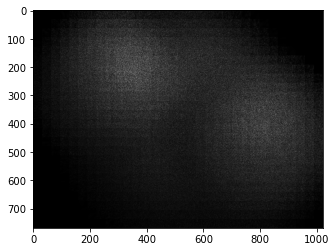

In [100]:
# %matplotlib auto
img=image.cpu()
plt.imshow(tc.abs(img),"gray")
# plt.show()

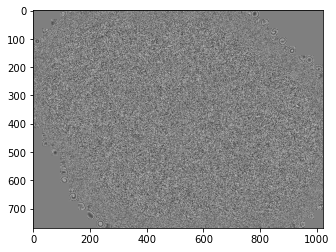

In [101]:
img=image.cpu()
plt.imshow(tc.angle(img),"gray")

In [82]:
I=np.abs(np.array(img))
window_name="show"
cv.namedWindow(window_name,0)
cv.setWindowProperty(window_name,cv.WND_PROP_FULLSCREEN,cv.WINDOW_FULLSCREEN)
cv.moveWindow(window_name,0,0)
cv.resizeWindow(window_name,h,w)
I=(I-np.min(I))/(np.max(I)-np.min(I))
cv.imshow(window_name,I)
cv.waitKey(0)

-1

In [13]:
cv.destroyAllWindows()

D:\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
D:\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


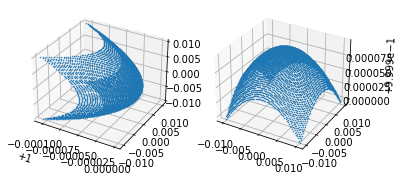

In [97]:
#虚拟光线限制在视锥体内(经纬线赤道附近)
theta=math.asin(lamda/(2*pixl))
N=int(2*theta/math.pi*180/(1/60))
cos_theta=tc.linspace(math.cos(math.pi/2-theta),math.cos(math.pi/2+theta),N)
sin_theta=tc.sqrt(1-cos_theta**2)
theta_N=tc.linspace(-theta,theta,N)
light_dir=tc.zeros(N**2,3)
light_dir[:,0]=tc.kron(sin_theta,tc.cos(theta_N))
light_dir[:,1]=tc.kron(sin_theta,tc.sin(theta_N))
light_dir[:,2]=tc.kron(cos_theta,tc.ones(N))
# %matplotlib auto
%matplotlib inline
plt.subplot(1,2,1,projection='3d')
plt.plot(light_dir[:,0],light_dir[:,1],light_dir[:,2],".",ms=1)
light_dir=light_dir[:,[2,1,0]]
plt.subplot(1,2,2,projection='3d')
plt.plot(light_dir[:,0],light_dir[:,1],light_dir[:,2],".",ms=1)

In [11]:
%%time
b=len(light_dir)
light_dir=light_dir.cuda()
image=tc.zeros(w,h,dtype=tc.cfloat).cuda()
# color_image=tc.zeros(w,h,3,dtype=tc.cfloat).cuda()
########
for i in range(int(w/pixl_num)):
    for j in range(int(h/pixl_num)):
        dis,index=shortest_dis(sence,origin_p[i,j],light_dir)
        coord=tc.unsqueeze(origin_p[i,j],dim=-2)+light_dir*tc.unsqueeze(dis,dim=-1)
        L=(souce["position"]-coord)/tc.unsqueeze(tc.norm(souce["position"]-coord,dim=-1),dim=-1)
        N=(coord-center[index])/tc.unsqueeze(tc.norm(coord-center[index],dim=-1),dim=-1)
        L_N=tc.matmul(tc.unsqueeze(L,dim=-2),tc.unsqueeze(N,dim=-1))
        R=2*tc.squeeze(L_N,dim=-1)*N-L
        V=tc.ones(R.size()).cuda()*(-light_dir)
        A=tc.squeeze(ka+kd*tc.clip(L_N,0)+ks*tc.clip(tc.matmul(tc.unsqueeze(R,dim=-2),tc.unsqueeze(V,dim=-1)),0)**alpha)
        #阴影
        #     shadow_dis=shadow(sence,coord,L,index)
        #     shadow_dis[shadow_dis== -tc.inf]=tc.inf
        #     shadow_dis[tc.isnan(shadow_dis)]=tc.inf
        #     A[shadow_dis!=tc.inf]=ka
        #
        coord[coord==tc.inf]=0
        coord[coord== -tc.inf]=0
        coord[tc.isnan(coord)]=0
        coord[...,2][coord[...,2]==0]=c
#         coord=coord.unsqueeze(dim=-2).unsqueeze(dim=-2)
#         di=tc.norm(origin_p[i][j]-coord,dim=-1)
#         x1=coord[...,0]-coord[...,2]*math.tan(theta)
#         x2=coord[...,0]+coord[...,2]*math.tan(theta)
#         y1=coord[...,1]-coord[...,2]*math.tan(theta)
#         y2=coord[...,1]+coord[...,2]*math.tan(theta)
        H=A/dis*tc.exp(1j*(2*tc.pi/lamda*dis))#+phi[(10*coord[...,0]+phi.size(0)/2).type(tc.LongTensor),(10*coord[...,1]+phi.size(1)/2).type(tc.LongTensor),(10*(coord[...,2]-c)).type(tc.LongTensor)].cuda()))
#.unsqueeze(dim=-1).unsqueeze(dim=-1)
    #         H[(origin_p[i][j][...,0]<x1)&(origin_p[i][j][...,0]>x2)&(origin_p[i][j][...,1]<y1)&(origin_p[i][j][...,1]>y2)]=0
        H[H==tc.inf]=0
        H[H== -tc.inf]=0
        H[tc.isnan(H)]=0
        image[pixl_num*i:pixl_num*(i+1),pixl_num*j:pixl_num*(j+1)]=tc.sum(H,dim=-1).reshape(pixl_num,pixl_num)

KeyboardInterrupt: 